# Coefficient field inversion in an elliptic partial differential equation

We consider the estimation of a coefficient in an elliptic partial differential equation as a first model problem.
Depending on the interpretation of the unknowns and the type of measurements, this model problem arises, for instance, in electrical impedence tomography.

Let $\Omega\subset\mathbb{R}^n$, $n\in\{1,2,3\}$ be an open, bounded
domain and consider the following problem:

$$
\min_{m} J(m):=\frac{1}{2}\int_{\Omega} (u-d)^2\, dx + \gamma\int_\Omega\sqrt{|\nabla m|^2+\beta}\,dx,
$$

where $u$ is the solution of

$$
\begin{split}
\quad -\nabla\cdot(e^m \nabla u) &= 0 \text{ in }\Omega,\\
e^m \nabla u &= j \text{ on }\partial\Omega.
\end{split}
$$

Here $m \in \mathcal{M}:=\{m\in L^{\infty}(\Omega) \bigcap H^1(\Omega)\}$ denotes the unknown parameter field, 
$u \in \mathcal{V}:= \left\{v \in H^1(\Omega) | v(\boldsymbol{x}_c) = 0 \text{ for a given point } \boldsymbol{x}_c\in \Omega \right\}$ the state variable, $d$ the (possibly noisy) data, $j\in H^{-1/2}(\partial\Omega)$ a given boundary force, and $\gamma\ge 0$ the regularization parameter.

### The variational (or weak) form of the forward problem:

Find $u\in \mathcal{V}$ such that 

$$ \int_{\Omega}e^m \nabla u \cdot \nabla \tilde{p} \, dx - \int_{\partial \Omega} j \tilde{p} \,dx = 0, \text{ for all } \tilde{p}\in \mathcal{V}.$$


### Gradient evaluation:

The Lagrangian functional $\mathscr{L}:\mathcal{V}\times\mathcal{M}\times\mathcal{V}\rightarrow \mathbb{R}$ is given by

$$
\mathscr{L}(u,m,p):= \frac{1}{2}\int_{\Omega}(u-u_d)^2 dx +
\gamma\int_\Omega \sqrt{|\nabla m|^2+\beta} dx +  \int_{\Omega} e^m\nabla u \cdot \nabla p dx 
- \int_{\partial \Omega} j\,p\, dx.
$$

Then the gradient of the cost functional $\mathcal{J}(m)$ with respect to the parameter $m$ in an arbitrary direction $\tilde m$ is

$$
    (\mathcal{G}(m), \tilde m) := \mathscr{L}_m(u,m,p)(\tilde{m}) = \gamma \int_\Omega \frac{\nabla m}{\sqrt{|\nabla m|^2+\beta}} \cdot \nabla \tilde{m}\, dx +
     \int_\Omega \tilde{m}e^m\nabla u \cdot \nabla p\, dx \quad \forall \tilde{m} \in \mathcal{M},
$$

where $u \in \mathcal{V}$ is the solution of the forward problem,

$$ (\mathscr{L}_p(u,m,p), \tilde{p})  := \int_{\Omega}e^m\nabla u \cdot \nabla \tilde{p}\, dx - \int_{\partial\Omega} j\,\tilde{p}\, dx = 0
\quad \forall \tilde{p} \in \mathcal{V}, $$

and $p \in \mathcal{V}$ is the solution of the adjoint problem,

$$ (\mathscr{L}_u(u,m,p), \tilde{u}) := \int_{\Omega} e^m\nabla p \cdot \nabla \tilde{u}\, dx + \int_{\Omega} (u-d)\tilde{u}\,dx = 0
\quad \forall \tilde{u} \in \mathcal{V}.$$

### Steepest descent method.

Written in abstract form, the steepest descent methods computes an update direction $\hat{m}_k$ in the direction of the negative gradient defined as 

$$
\int_\Omega \hat{m}_k \tilde{m}\, dx = -\left(\mathcal{G}(m_k), \tilde m\right) \quad \forall \tilde{m} \in \mathcal{M},
$$

where the evaluation of the gradient $\mathcal{G}(m_k)$ involve the solution $u_k$ and $p_k$ of the forward and adjoint problem (respectively) for $m = m_k$.

Then we set $m_{k+1} = m_k + \alpha \hat{m}_k$, where the step length $\alpha$ is chosen to guarantee sufficient descent. 


### Goals:

By the end of this notebook, you should be able to:

- solve the forward and adjoint Poisson equations
- understand the inverse method framework
- visualise and understand the results
- modify the problem and code

### Mathematical tools used:

- Finite element method
- Derivation of gradient via the adjoint method
- Armijo line search

### Import dependencies

In [1]:
from __future__ import print_function, division, absolute_import

import matplotlib.pyplot as plt
%matplotlib inline

import dolfin as dl
from hippylib import nb

import numpy as np
import logging


logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)

### Model set up:

As in the introduction, the first thing we need to do is to set up the numerical model.

In this cell, we set the mesh ``mesh``, the finite element spaces ``Vm`` and ``Vu`` corresponding to the parameter space and state/adjoint space, respectively. In particular, we use linear finite elements for the parameter space, and quadratic elements for the state/adjoint space.

The true parameter ``mtrue`` is the finite element interpolant of the function

$$ m_{\rm true} = \left\{ \begin{array}{l} \ln 4 \; \forall \,(x,y) \, {\rm s.t.}\, \sqrt{ (x-.5)^2 + (y-.5)^2} \leq 0.2 \\ \ln 8 \; {\rm otherwise}. \end{array}\right. $$

The forcing term ``j`` for the forward problem is

$$ j(x,y) = (x - 0.5)y(y-1) \; \forall {\boldsymbol{x}=(x,y)} \in \partial\Omega. $$

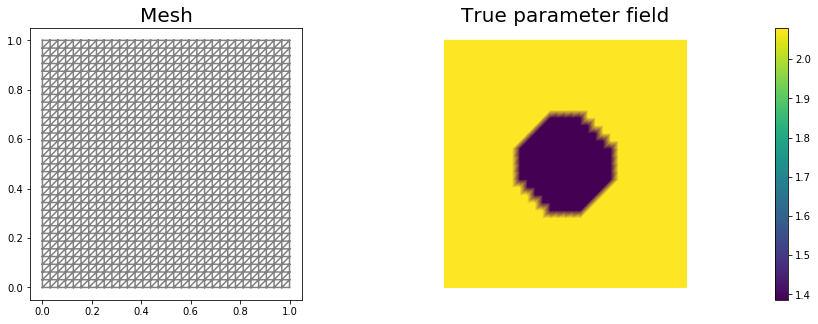

In [2]:
# create mesh and define function spaces
nx = 32
ny = 32
mesh = dl.UnitSquareMesh(nx, ny)
Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

# The true and initial guess for inverted parameter
mtrue = dl.interpolate(dl.Expression('std::log( 8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) ) )', degree=5), Vm)

# define function for state and adjoint
u = dl.Function(Vu)
m = dl.Function(Vm)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

# initialize input functions
j  = dl.Expression("(x[0]-.5)*x[1]*(x[1]-1)", degree=3)

# plot
plt.figure(figsize=(15,5))
nb.plot(mesh, subplot_loc=121, mytitle="Mesh", show_axis='on')
nb.plot(mtrue, subplot_loc=122, mytitle="True parameter field")
plt.show()

In [3]:
# Fix the value of the state at the center of the domain
def d_boundary(x,on_boundary):
    return dl.near(x[0], .5) and dl.near(x[1], .5)

u0 = dl.Constant(0.)
bc_state = dl.DirichletBC(Vu, u0, d_boundary, "pointwise")
bc_adj   = dl.DirichletBC(Vu, dl.Constant(0.), d_boundary, "pointwise")

### Set up synthetic observations (inverse crime):

To generate the synthetic observation we first solve the PDE for the state variable ``utrue`` corresponding to the true parameter ``mtrue``.
Specifically, we solve the variational problem

Find $u\in \mathcal{V}$ such that 

$$\underbrace{\int_\Omega e^{m_{\text true}} \nabla u \cdot \nabla v \, dx}_{\; := \; a_{\rm true}} - \underbrace{\int_{\partial\Omega} j\,v\,dx}_{\; := \;L_{\rm true}} = 0, \text{ for all } v\in \mathcal{V}$$.

Then we perturb the true state variable and write the observation ``d`` as

$$ d = u_{\rm true} + \eta, \quad {\rm where} \; \eta \sim \mathcal{N}(0, \sigma^2).$$

Here the standard variation $\sigma$ is proportional to ``noise_level``.

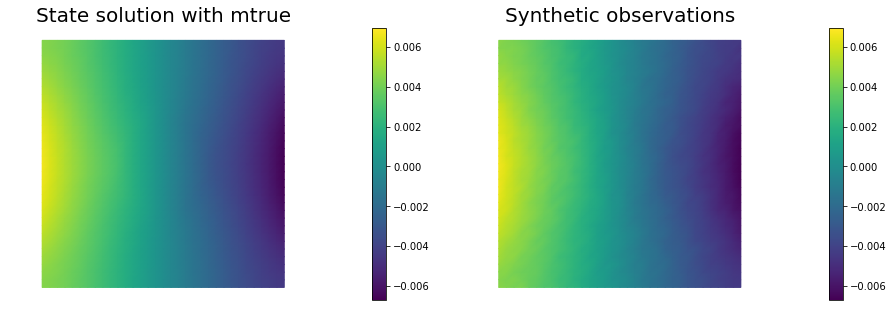

In [4]:
# noise level
noise_level = 0.01

# weak form for setting up the synthetic observations
a_true = dl.inner( dl.exp(mtrue) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
L_true = j * u_test * dl.ds

# solve the forward/state problem to generate synthetic observations
A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)

utrue = dl.Function(Vu)
dl.solve(A_true, utrue.vector(), b_true)

d = dl.Function(Vu)
d.assign(utrue)

# perturb state solution and create synthetic measurements d
# d = u + ||u||/SNR * random.normal
MAX = d.vector().norm("linf")
noise = dl.Vector()
A_true.init_vector(noise,1)
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(d.vector().get_local())) )
bc_adj.apply(noise)

d.vector().axpy(1., noise)

# plot
nb.multi1_plot([utrue, d], ["State solution with mtrue", "Synthetic observations"])
plt.show()

### The cost functional evaluation:

$$
J(m):=\underbrace{\frac{1}{2}\int_\Omega (u-d)^2\, dx}_{\text misfit} + \underbrace{\gamma \int_\Omega\sqrt{|\nabla m|^2+\beta}\,dx}_{\text{reg}}
$$

In [5]:
# Regularization parameter
gamma = 1e-9
beta  = 0.1

# Define cost function
def cost(u, d, m, gamma, beta):
    reg = dl.assemble( dl.sqrt(dl.inner(dl.grad(m), dl.grad(m))+dl.Constant(beta))*dl.dx ) 
    misfit = 0.5 * dl.assemble( (u-d)**2*dl.dx)
    return [gamma*reg + misfit, misfit, reg]

### Setting up the variational form for the state/adjoint equations and gradient evaluation

Below we define the variational forms that appears in the the state/adjoint equations and gradient evaluations.

Specifically,

- `a_state`, `L_state` stand for the bilinear and linear form of the state equation, repectively;
- `a_adj`, `L_adj` stand for the bilinear and linear form of the adjoint equation, repectively;
- `grad_misfit`, `grad_reg` stand for the contributions to the gradient coming from the data misfit and the regularization, respectively.

We also build the *mass* matrix $M$ that is used to discretize the $L^2(\Omega)$ inner product.

In [6]:
# weak form for setting up the state equation
a_state = dl.inner( dl.exp(m) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx
L_state = j * u_test * dl.ds

# weak form for setting up the adjoint equations
a_adj = dl.inner( dl.exp(m) * dl.grad(p_trial), dl.grad(p_test) ) * dl.dx
L_adj = - dl.inner(u - d, p_test) * dl.dx

# weak form for gradient
grad_misfit = dl.inner(dl.exp(m)*m_test*dl.grad(u), dl.grad(p)) * dl.dx
grad_reg    = (dl.Constant(gamma)/dl.sqrt(dl.inner(dl.grad(m), dl.grad(m))+dl.Constant(beta))
               *dl.inner(dl.grad(m), dl.grad(m_test)))*dl.dx

# Mass matrix in parameter space
Mvarf    = dl.inner(m_trial, m_test) * dl.dx
M = dl.assemble(Mvarf)

### Finite difference check of the gradient

We use a **finite difference check** to verify that our gradient derivation is correct.
Specifically, we consider a function $ m_0\in \mathcal{M}$ and we verify that for an arbitrary direction $\tilde{m} \in \mathcal{M}$ we have
$$ r := \left| \frac{ \mathcal{J}(m_0 + \varepsilon \tilde{m}) - \mathcal{J}(m_0)}{\varepsilon} -  \left(\mathcal{G}(m_0), \tilde{m}\right)\right| = \mathcal{O}(\varepsilon).$$

In the figure below we show in a loglog scale the value of $r$ as a function of $\varepsilon$. We observe that $r$ decays linearly for a wide range of values of $\varepsilon$, however we notice an increase in the error for extremely small values of $\varepsilon$ due to numerical stability and finite precision arithmetic.


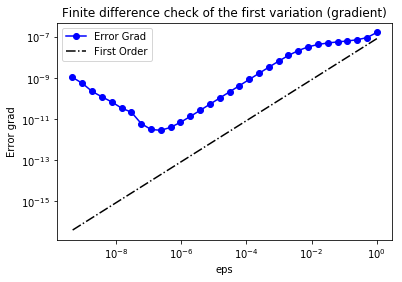

In [7]:
m0 = dl.interpolate(dl.Constant(np.log(4.) ), Vm )

n_eps = 32
eps = np.power(2., -np.arange(n_eps))
err_grad = np.zeros(n_eps)

m.assign(m0)

#Solve the fwd problem and evaluate the cost functional
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

c0, _, _ = cost(u, d, m, gamma, beta)

# Solve the adjoint problem and evaluate the gradient
adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
dl.solve(adj_A, p.vector(), adjoint_RHS)

# evaluate the  gradient
grad0 = dl.assemble(grad_misfit + grad_reg)

# Define an arbitrary direction m_hat to perform the check 
mtilde = dl.Function(Vm).vector()
mtilde.set_local(np.random.randn(Vm.dim()))
mtilde.apply("")
mtilde_grad0 = grad0.inner(mtilde)

for i in range(n_eps):
    m.assign(m0)
    m.vector().axpy(eps[i], mtilde)
    
    A, state_b = dl.assemble_system (a_state, L_state, bc_state)
    dl.solve(A, u.vector(), state_b)

    cplus, _, _ = cost(u, d, m, gamma, beta)
   
    err_grad[i] = abs( (cplus - c0)/eps[i] - mtilde_grad0 )

plt.figure()    
plt.loglog(eps, err_grad, "-ob", label="Error Grad")
plt.loglog(eps, (.5*err_grad[0]/eps[0])*eps, "-.k", label="First Order")
plt.title("Finite difference check of the first variation (gradient)")
plt.xlabel("eps")
plt.ylabel("Error grad")
plt.legend(loc = "upper left")
plt.show()

### Initial guess

We solve the state equation and compute the cost functional for the initial guess of the parameter ``m0``

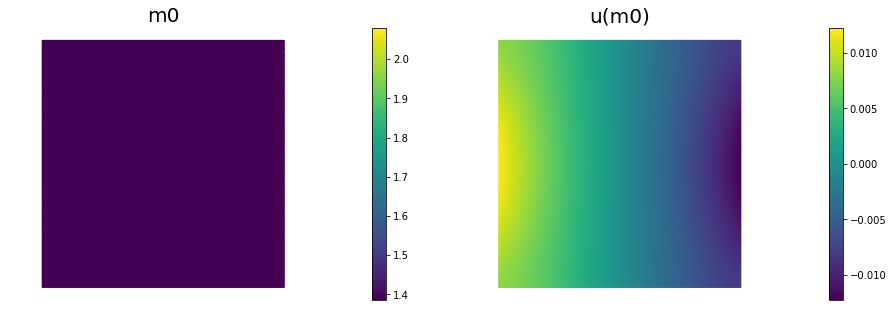

In [8]:
m.assign(m0)

# solve state equation
A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve(A, u.vector(), state_b)

# evaluate cost
[cost_old, misfit_old, reg_old] = cost(u, d, m, gamma, beta)

# plot
plt.figure(figsize=(15,5))
nb.plot(m,subplot_loc=121, mytitle="m0", vmin=mtrue.vector().min(), vmax=mtrue.vector().max())
nb.plot(u,subplot_loc=122, mytitle="u(m0)")
plt.show()

## The steepest descent with Armijo line search:

We solve the constrained optimization problem using the steepest descent method with Armijo line search.

The stopping criterion is based on a relative reduction of the norm of the gradient (i.e. $\frac{\|g_{n}\|}{\|g_{0}\|} \leq \tau$).

The gradient is computed by solving the state and adjoint equation for the current parameter $m$, and then substituing the current state $u$, parameter $m$ and adjoint $p$ variables in the weak form expression of the gradient:

$$ (g, \tilde{m}) = \gamma\int_\Omega \frac{\nabla m}{\sqrt{|\nabla m|^2+\beta}} \cdot \nabla \tilde{m}\, dx +\int_\Omega \tilde{m}\,e^m\nabla u \cdot \nabla p\, dx.$$

The Armijo line search uses backtracking to find $\alpha$ such that a sufficient reduction in the cost functional is achieved.
Specifically, we use backtracking to find $\alpha$ such that:

$$J( m - \alpha g ) \leq J(m) - \alpha c_{\rm armijo} \|g\|^2. $$


Nit  cost          misfit        reg         ||grad||       alpha  N backtrack
  0   2.97888e-06   2.97418e-06   4.69825e+00   1.72104e-05   1.00000e+05     0


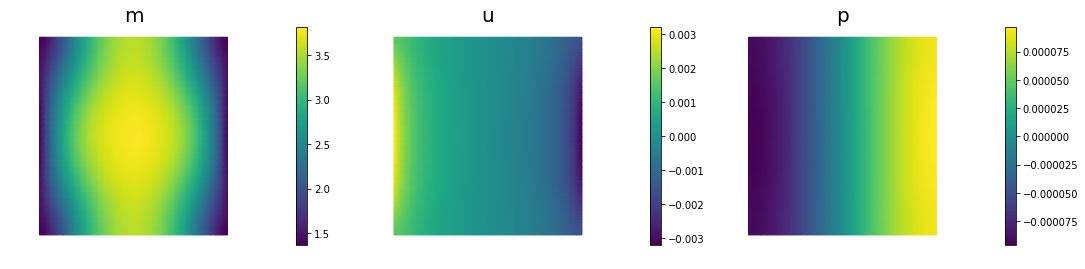

 10   2.92252e-08   2.74945e-08   1.73070e+00   3.66732e-07   1.00000e+05     0
 20   1.00761e-08   8.22491e-09   1.85123e+00   1.44978e-07   1.00000e+05     0
 30   6.49244e-09   4.62092e-09   1.87152e+00   7.45297e-08   1.00000e+05     0
 40   5.27665e-09   3.44608e-09   1.83057e+00   1.06478e-07   2.50000e+04     2
 50   4.70716e-09   2.93126e-09   1.77590e+00   7.48934e-08   2.50000e+04     2


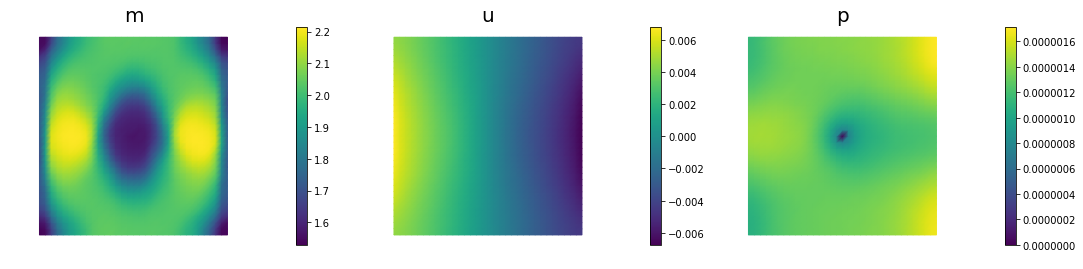

 60   4.35559e-09   2.63532e-09   1.72027e+00   3.86067e-08   5.00000e+04     1
 70   4.11647e-09   2.43756e-09   1.67892e+00   4.23426e-08   5.00000e+04     1
 80   3.89890e-09   2.27144e-09   1.62746e+00   2.86186e-08   5.00000e+04     1
 90   3.73954e-09   2.14968e-09   1.58986e+00   2.66312e-08   5.00000e+04     1
100   3.60809e-09   2.05016e-09   1.55794e+00   2.59082e-08   5.00000e+04     1


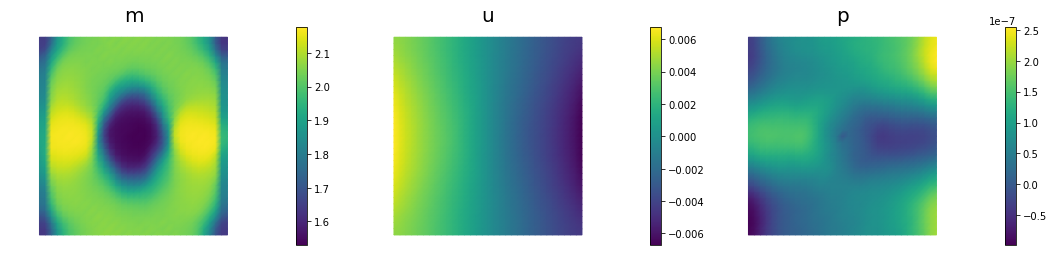

110   3.49671e-09   1.96700e-09   1.52971e+00   2.54899e-08   5.00000e+04     1
120   3.39244e-09   1.90070e-09   1.49174e+00   2.53025e-08   2.50000e+04     2
130   3.31125e-09   1.84453e-09   1.46671e+00   2.42359e-08   2.50000e+04     2
140   3.24633e-09   1.79632e-09   1.45001e+00   2.03430e-08   5.00000e+04     1
150   3.17870e-09   1.75740e-09   1.42130e+00   3.57013e-08   2.50000e+04     2


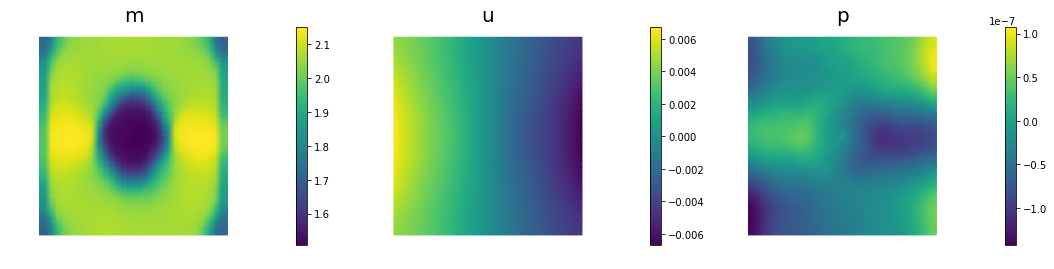

160   3.12280e-09   1.72325e-09   1.39955e+00   3.54819e-08   2.50000e+04     2
170   3.07336e-09   1.69533e-09   1.37802e+00   1.96935e-08   2.50000e+04     2
180   3.02736e-09   1.66843e-09   1.35894e+00   3.22011e-08   2.50000e+04     2
190   2.98474e-09   1.64628e-09   1.33846e+00   1.97196e-08   2.50000e+04     2
200   2.94640e-09   1.62637e-09   1.32003e+00   1.90118e-08   2.50000e+04     2


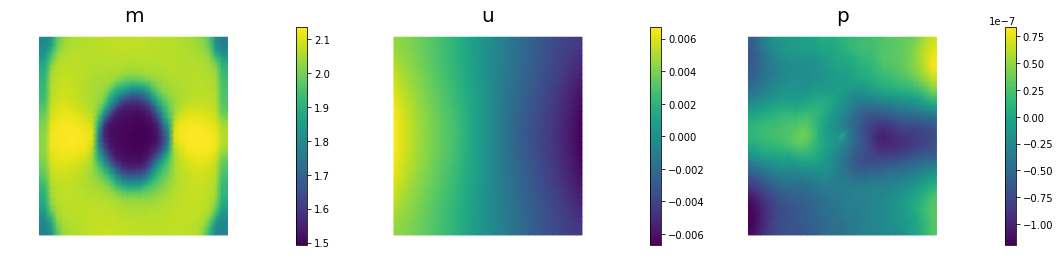

210   2.91061e-09   1.60844e-09   1.30217e+00   1.89745e-08   2.50000e+04     2
220   2.87707e-09   1.59225e-09   1.28482e+00   1.90064e-08   2.50000e+04     2
230   2.84683e-09   1.57761e-09   1.26922e+00   2.68745e-08   2.50000e+04     2
240   2.81791e-09   1.56539e-09   1.25252e+00   1.52271e-08   2.50000e+04     2
250   2.79103e-09   1.55324e-09   1.23779e+00   2.07307e-08   2.50000e+04     2


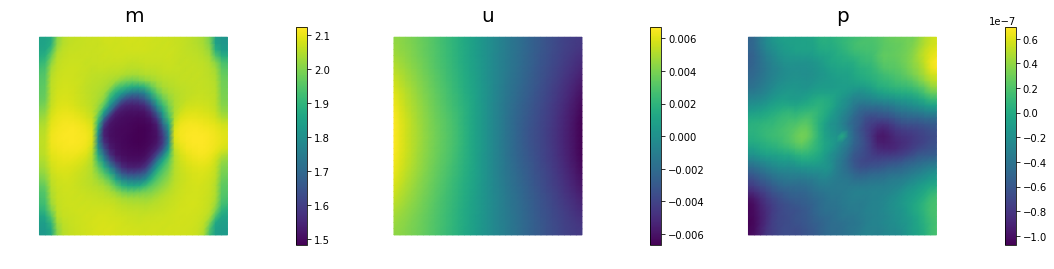

260   2.76620e-09   1.54306e-09   1.22314e+00   1.47514e-08   2.50000e+04     2
270   2.74344e-09   1.53288e-09   1.21056e+00   2.52562e-08   2.50000e+04     2
280   2.72103e-09   1.52430e-09   1.19673e+00   1.58187e-08   2.50000e+04     2
290   2.70104e-09   1.51636e-09   1.18468e+00   1.30054e-08   2.50000e+04     2
300   2.68386e-09   1.50832e-09   1.17554e+00   1.13795e-08   5.00000e+04     1


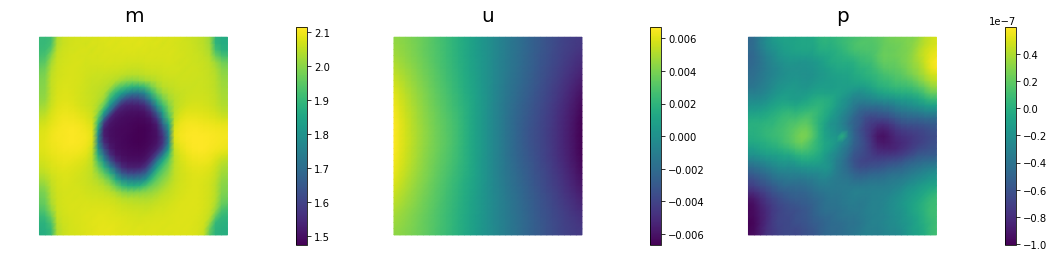

310   2.66501e-09   1.50144e-09   1.16357e+00   1.83698e-08   2.50000e+04     2
320   2.64864e-09   1.49500e-09   1.15364e+00   1.43172e-08   2.50000e+04     2
330   2.63371e-09   1.48895e-09   1.14476e+00   1.25648e-08   2.50000e+04     2
340   2.61986e-09   1.48326e-09   1.13660e+00   1.14058e-08   2.50000e+04     2
350   2.60695e-09   1.47791e-09   1.12904e+00   1.05226e-08   2.50000e+04     2


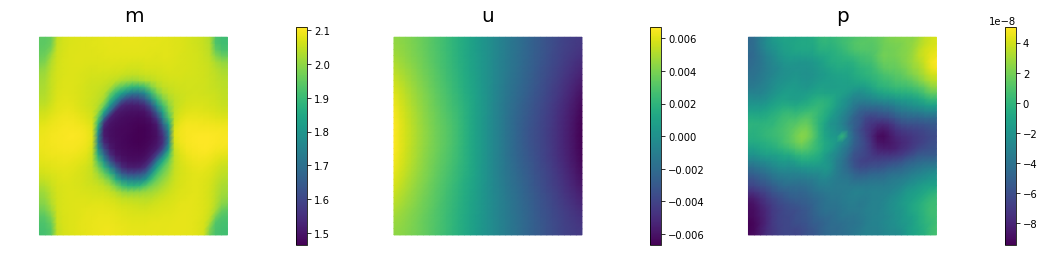

360   2.59489e-09   1.47286e-09   1.12203e+00   9.79469e-09   2.50000e+04     2
370   2.58465e-09   1.46769e-09   1.11697e+00   9.17561e-09   5.00000e+04     1
380   2.57385e-09   1.46322e-09   1.11064e+00   8.63227e-09   5.00000e+04     1
390   2.56393e-09   1.45900e-09   1.10493e+00   8.34843e-09   5.00000e+04     1
400   2.55466e-09   1.45501e-09   1.09965e+00   8.13903e-09   5.00000e+04     1


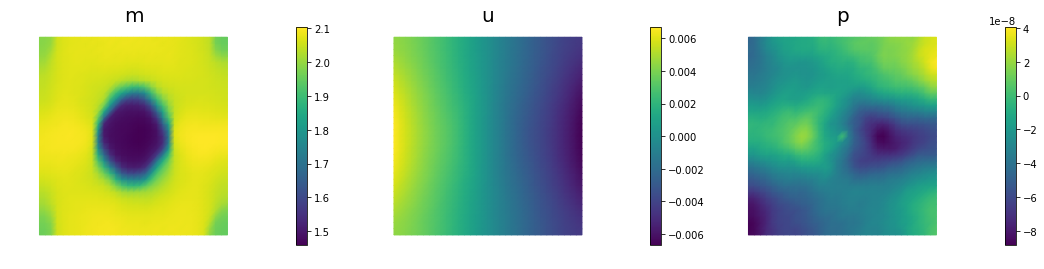

410   2.54597e-09   1.45126e-09   1.09471e+00   7.95787e-09   5.00000e+04     1
420   2.53781e-09   1.44772e-09   1.09009e+00   7.78910e-09   5.00000e+04     1
430   2.52940e-09   1.44468e-09   1.08472e+00   7.62592e-09   2.50000e+04     2
440   2.52223e-09   1.44154e-09   1.08069e+00   7.66876e-09   2.50000e+04     2
450   2.51556e-09   1.43858e-09   1.07697e+00   7.81099e-09   2.50000e+04     2


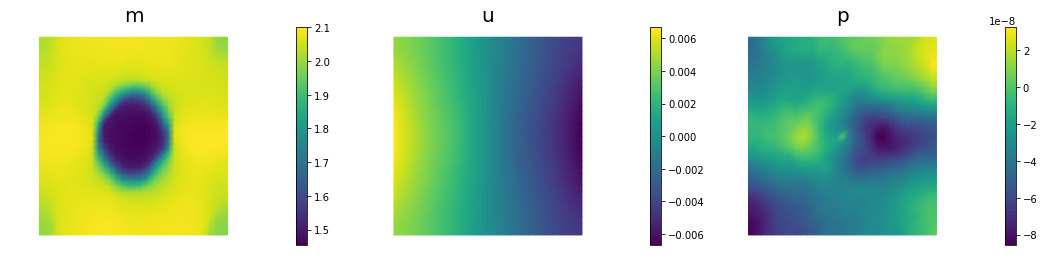

460   2.50939e-09   1.43581e-09   1.07357e+00   8.03992e-09   2.50000e+04     2
470   2.50373e-09   1.43321e-09   1.07052e+00   8.35975e-09   2.50000e+04     2
480   2.49865e-09   1.43076e-09   1.06789e+00   9.22124e-09   2.50000e+04     2
490   2.49426e-09   1.42846e-09   1.06580e+00   1.16970e-08   2.50000e+04     2
500   2.48999e-09   1.42649e-09   1.06350e+00   5.82687e-09   2.50000e+04     2


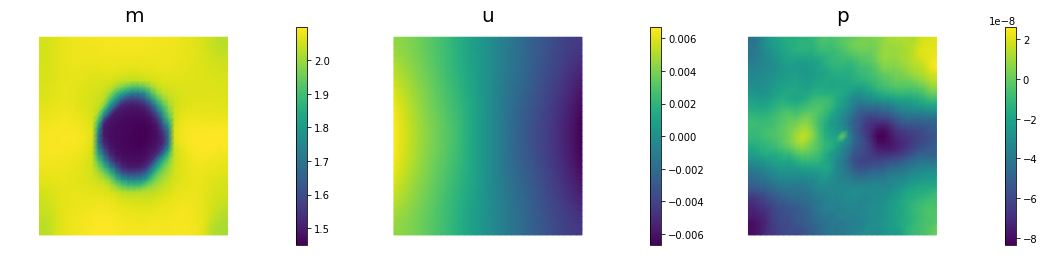

510   2.48641e-09   1.42443e-09   1.06198e+00   6.95690e-09   2.50000e+04     2
520   2.48337e-09   1.42267e-09   1.06070e+00   5.05435e-09   2.50000e+04     2
530   2.48078e-09   1.42101e-09   1.05977e+00   4.54836e-09   2.50000e+04     2
540   2.47853e-09   1.41943e-09   1.05910e+00   4.46615e-09   2.50000e+04     2
550   2.47657e-09   1.41795e-09   1.05862e+00   4.55215e-09   2.50000e+04     2


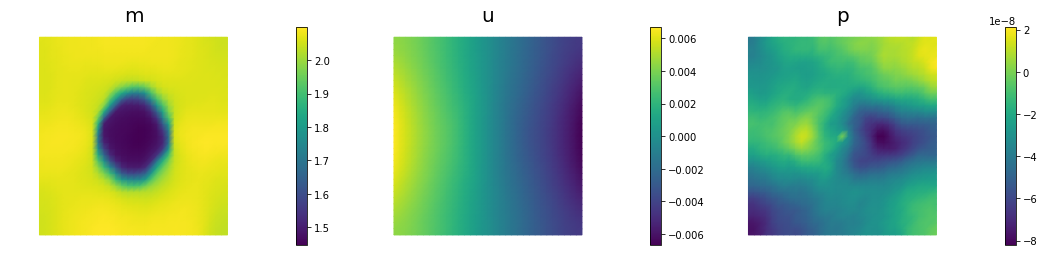

560   2.47486e-09   1.41655e-09   1.05831e+00   4.73534e-09   2.50000e+04     2
570   2.47337e-09   1.41523e-09   1.05814e+00   5.02438e-09   2.50000e+04     2
580   2.47208e-09   1.41399e-09   1.05809e+00   5.45127e-09   2.50000e+04     2
590   2.47095e-09   1.41282e-09   1.05812e+00   5.84781e-09   2.50000e+04     2
600   2.46995e-09   1.41172e-09   1.05823e+00   6.14740e-09   2.50000e+04     2


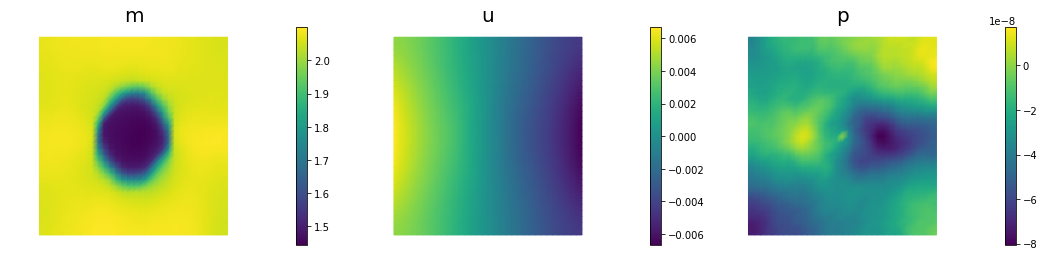

610   2.46907e-09   1.41068e-09   1.05838e+00   6.38872e-09   2.50000e+04     2
620   2.46828e-09   1.40971e-09   1.05858e+00   6.58128e-09   2.50000e+04     2
630   2.46759e-09   1.40878e-09   1.05880e+00   6.73017e-09   2.50000e+04     2
640   2.46696e-09   1.40791e-09   1.05905e+00   6.84275e-09   2.50000e+04     2
650   2.46640e-09   1.40709e-09   1.05932e+00   6.92701e-09   2.50000e+04     2


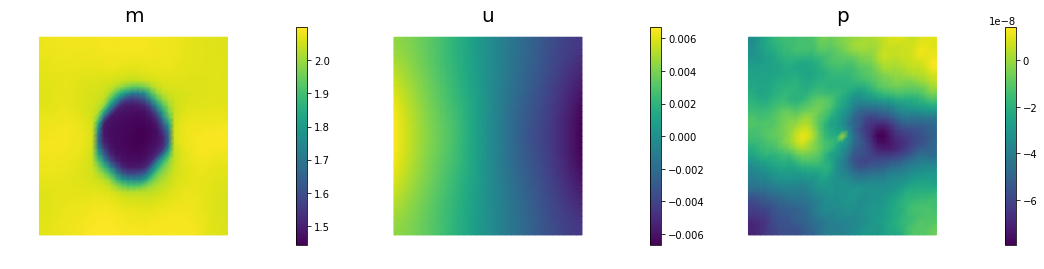

660   2.46590e-09   1.40631e-09   1.05959e+00   6.99040e-09   2.50000e+04     2
670   2.46545e-09   1.40557e-09   1.05988e+00   7.03952e-09   2.50000e+04     2
680   2.46504e-09   1.40487e-09   1.06017e+00   7.08058e-09   2.50000e+04     2
690   2.46467e-09   1.40420e-09   1.06046e+00   7.12064e-09   2.50000e+04     2
700   2.46433e-09   1.40357e-09   1.06076e+00   7.16985e-09   2.50000e+04     2


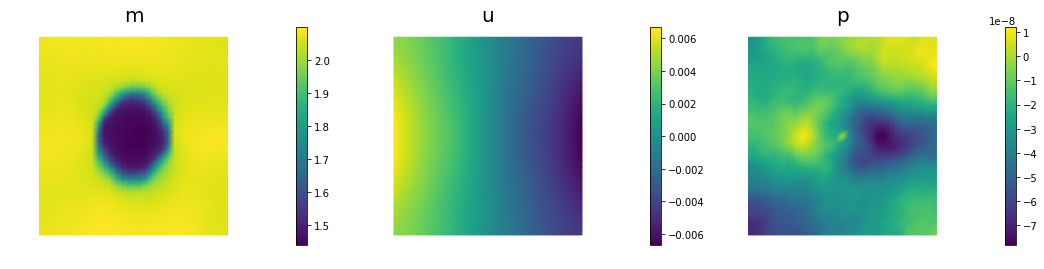

710   2.46403e-09   1.40297e-09   1.06105e+00   7.24529e-09   2.50000e+04     2
720   2.46375e-09   1.40240e-09   1.06135e+00   7.37535e-09   2.50000e+04     2
730   2.46351e-09   1.40186e-09   1.06165e+00   7.59723e-09   2.50000e+04     2
740   2.46331e-09   1.40134e-09   1.06197e+00   7.93131e-09   2.50000e+04     2
750   2.46312e-09   1.40085e-09   1.06228e+00   8.33971e-09   2.50000e+04     2


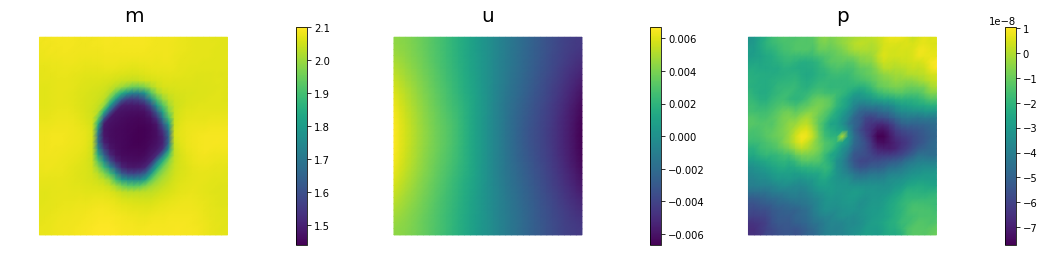

760   2.46296e-09   1.40037e-09   1.06259e+00   8.73441e-09   2.50000e+04     2
770   2.46280e-09   1.39992e-09   1.06288e+00   9.04681e-09   2.50000e+04     2
780   2.46265e-09   1.39949e-09   1.06316e+00   9.26317e-09   2.50000e+04     2
790   2.46249e-09   1.39907e-09   1.06342e+00   9.40306e-09   2.50000e+04     2
800   2.46235e-09   1.39868e-09   1.06367e+00   9.49202e-09   2.50000e+04     2


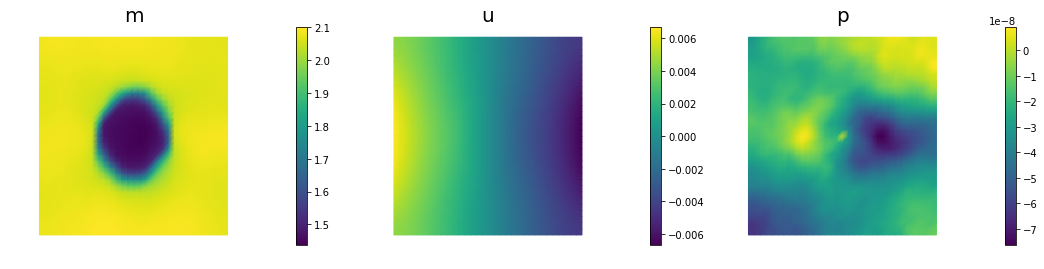

810   2.46221e-09   1.39830e-09   1.06391e+00   9.54994e-09   2.50000e+04     2
820   2.46207e-09   1.39793e-09   1.06414e+00   9.58970e-09   2.50000e+04     2
830   2.46194e-09   1.39758e-09   1.06436e+00   9.61896e-09   2.50000e+04     2
840   2.46182e-09   1.39725e-09   1.06458e+00   9.64211e-09   2.50000e+04     2
850   2.46171e-09   1.39692e-09   1.06478e+00   9.66163e-09   2.50000e+04     2


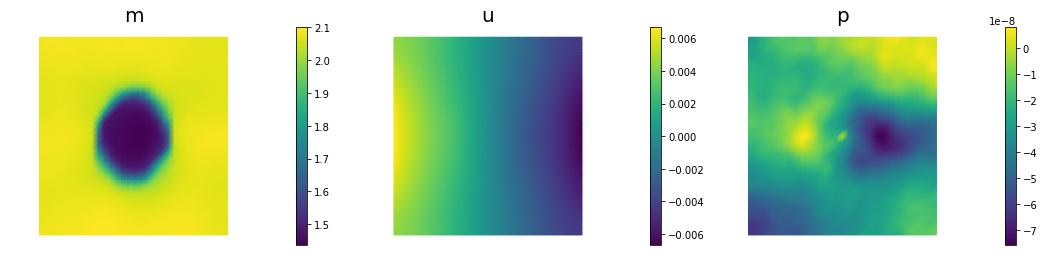

860   2.46160e-09   1.39661e-09   1.06499e+00   9.67890e-09   2.50000e+04     2
870   2.46150e-09   1.39631e-09   1.06518e+00   9.69471e-09   2.50000e+04     2
880   2.46140e-09   1.39603e-09   1.06537e+00   9.70953e-09   2.50000e+04     2
890   2.46130e-09   1.39575e-09   1.06556e+00   9.72362e-09   2.50000e+04     2
900   2.46121e-09   1.39548e-09   1.06573e+00   9.73715e-09   2.50000e+04     2


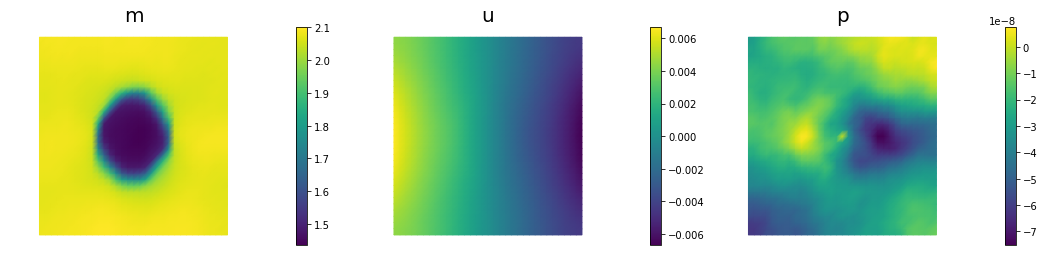

910   2.46113e-09   1.39522e-09   1.06591e+00   9.75023e-09   2.50000e+04     2
920   2.46105e-09   1.39497e-09   1.06607e+00   9.76293e-09   2.50000e+04     2
930   2.46097e-09   1.39473e-09   1.06624e+00   9.77531e-09   2.50000e+04     2
940   2.46090e-09   1.39450e-09   1.06640e+00   9.78740e-09   2.50000e+04     2
950   2.46083e-09   1.39428e-09   1.06655e+00   9.79923e-09   2.50000e+04     2


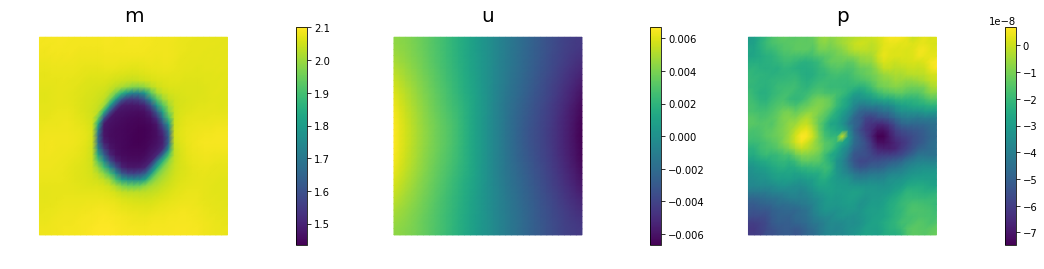

960   2.46076e-09   1.39406e-09   1.06670e+00   9.81082e-09   2.50000e+04     2
970   2.46069e-09   1.39385e-09   1.06685e+00   9.82219e-09   2.50000e+04     2
980   2.46063e-09   1.39365e-09   1.06699e+00   9.83335e-09   2.50000e+04     2
990   2.46057e-09   1.39345e-09   1.06712e+00   9.84432e-09   2.50000e+04     2
Steepest descent did not converge in  1000  iterations


In [9]:
# define parameters for the optimization
tol = 1e-4
maxiter = 1000
print_any = 10
plot_any = 50
c_armijo = 1e-5

# initialize iter counters
iter = 0
converged = False

# initializations
g = dl.Vector()
M.init_vector(g,0)

m_prev = dl.Function(Vm)

print( "Nit  cost          misfit        reg         ||grad||       alpha  N backtrack" )

while iter <  maxiter and not converged:

    # solve the adoint problem
    adj_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
    dl.solve(adj_A, p.vector(), adjoint_RHS)

    # evaluate the  gradient
    MG = dl.assemble(grad_misfit + grad_reg)
    dl.solve(M, g, MG)

    # calculate the norm of the gradient
    grad_norm2 = g.inner(MG)
    gradnorm = np.sqrt(grad_norm2)
    
    if iter == 0:
        gradnorm0 = gradnorm

    # linesearch
    it_backtrack = 0
    m_prev.assign(m)
    alpha = 1.e5
    backtrack_converged = False
    for it_backtrack in range(20):
        
        m.vector().axpy(-alpha, g )

        # solve the forward problem
        state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
        dl.solve(state_A, u.vector(), state_b)

        # evaluate cost
        [cost_new, misfit_new, reg_new] = cost(u, d, m, gamma, beta)

        # check if Armijo conditions are satisfied
        if cost_new < cost_old - alpha * c_armijo * grad_norm2:
            cost_old = cost_new
            backtrack_converged = True
            break
        else:
            alpha *= 0.5
            m.assign(m_prev)  # reset m
            
    if backtrack_converged == False:
        print( "Backtracking failed. A sufficient descent direction was not found" )
        converged = False
        break

    sp = ""
    if (iter % print_any)== 0 :
        print( "%3d %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %3d" % \
            (iter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
            gradnorm, sp, alpha, sp, it_backtrack) )

    if (iter % plot_any)== 0 :
        nb.multi1_plot([m,u,p], ["m","u","p"], same_colorbar=False)
        plt.show()
    
    # check for convergence
    if gradnorm < tol*gradnorm0 and iter > 0:
        converged = True
        print ("Steepest descent converged in ",iter,"  iterations")
        
    iter += 1
    
if not converged:
    print ( "Steepest descent did not converge in ", maxiter, " iterations")

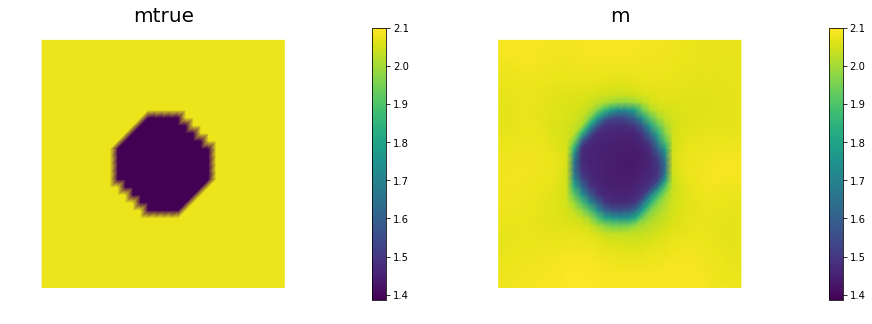

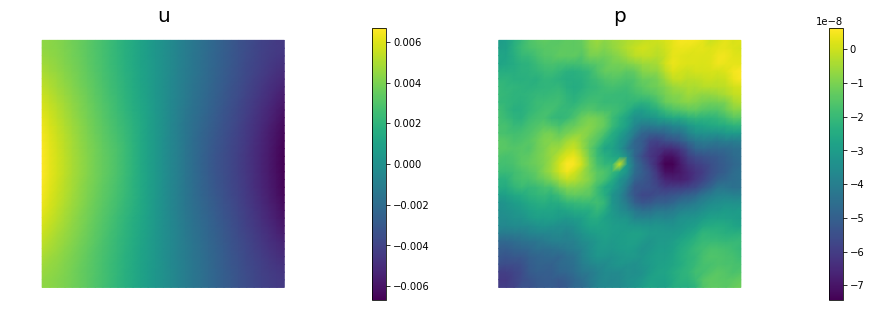

In [10]:
nb.multi1_plot([mtrue, m], ["mtrue", "m"])
nb.multi1_plot([u,p], ["u","p"], same_colorbar=False)
plt.show()

---

Copyright &copy; 2019, Washington University in St. Louis.

All Rights reserved.
See file COPYRIGHT for details.

This file is part of **cmis_labs**, the teaching material for the S2019 BME 493/593 course on *Computational Methods in Imaging Science* at Washington University in St. Louis. Please see [https://uvilla.github.io/cmis_labs](https://uvilla.github.io/cmis_labs) for more information and source code availability.

We would like to acknowledge the Extreme Science and Engineering Discovery Environment (XSEDE), which is supported by National Science Foundation grant number ACI-1548562, for providing cloud computing resources (Jetstream) for this course through allocation TG-SEE190001.